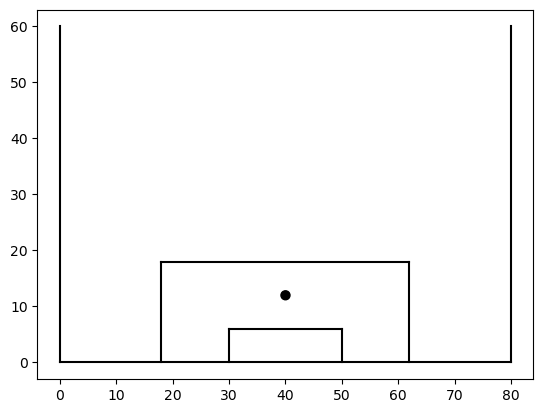

In [2]:
#The basics
import pandas as pd
import numpy as np
import json

#Xg MODEL
from expectedGoal import xG

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

from os import listdir
from os.path import isfile, join

In [3]:
#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
onlyfiles = [f[:-5] for f in listdir('wyscoutEvents/events') if isfile(join('wyscoutEvents/events', f))]
onlyfiles

['events_European_Championship',
 'events_Italy',
 'events_World_Cup',
 'events_Germany',
 'events_Spain',
 'events_France',
 'events_England']

In [4]:
data = []
for i in onlyfiles:
    with open('wyscoutEvents/events/'+i+'.json') as f:
        js = json.load(f)
        df = pd.DataFrame(js)
        data.append(df)


In [5]:
train = pd.concat(data,ignore_index=True)

In [75]:
dfs

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],26010,"[{'y': 48, 'x': 50}, {'y': 50, 'x': 47}]",1694390,Pass,4418,1H,1.255990,85,88178642
1,8,Simple pass,[{'id': 1801}],3682,"[{'y': 50, 'x': 47}, {'y': 48, 'x': 41}]",1694390,Pass,4418,1H,2.351908,85,88178643
2,8,Simple pass,[{'id': 1801}],31528,"[{'y': 48, 'x': 41}, {'y': 35, 'x': 32}]",1694390,Pass,4418,1H,3.241028,85,88178644
3,8,High pass,[{'id': 1802}],7855,"[{'y': 35, 'x': 32}, {'y': 6, 'x': 89}]",1694390,Pass,4418,1H,6.033681,83,88178645
4,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",25437,"[{'y': 6, 'x': 89}, {'y': 0, 'x': 85}]",1694390,Duel,4418,1H,13.143591,12,88178646
...,...,...,...,...,...,...,...,...,...,...,...,...
3251289,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
3251290,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
3251291,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
3251292,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [78]:
#Create a data set of shots.
#train = pd.DataFrame(data)
#only want the shots
cross=train[train['subEventId']==80]
#create empty data frame
#shots_model=pd.DataFrame(columns=['Goal','X','Y'])


In [3]:
len(train['matchId'].unique())

380

In [14]:
cross.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

In [17]:
cross['eventSec']

45          93.961235
75         228.764258
80         235.809436
86         251.068319
137        486.183517
             ...     
642828    1482.329472
642900    1809.230004
642989    2079.858095
643096    2642.981466
643143    2789.232666
Name: eventSec, Length: 12251, dtype: float64

In [4]:
cross['tags']

45        [{'id': 301}, {'id': 402}, {'id': 801}, {'id':...
75        [{'id': 1901}, {'id': 401}, {'id': 2101}, {'id...
80                              [{'id': 401}, {'id': 1801}]
86                 [{'id': 402}, {'id': 801}, {'id': 1802}]
137                             [{'id': 401}, {'id': 1802}]
                                ...                        
642828             [{'id': 401}, {'id': 801}, {'id': 1802}]
642900             [{'id': 302}, {'id': 402}, {'id': 1801}]
642989             [{'id': 402}, {'id': 801}, {'id': 1801}]
643096                          [{'id': 402}, {'id': 1802}]
643143            [{'id': 402}, {'id': 2101}, {'id': 1802}]
Name: tags, Length: 12251, dtype: object

In [91]:
pitchLengthX=120
pitchWidthY=80
startx =[]
starty= []
endx=[]
endy=[]
for i,cro in cross.iterrows():
    if cro['positions'][0]['y'] < 50:
        c = cro['positions'][0]['y'] + 50
        y = cro['positions'][0]['y'] + (2*c)
    else:
        y = cro['positions'][0]['y']
    #print(cro['positions'][0])
    startx.append((cro['positions'][0]['x']/100)*pitchLengthX)
    starty.append((y/100)*pitchWidthY)
    if (cro['positions'][1]['x'] ==100 and cro['positions'][1]['y'] ==100):
        continue
    elif(cro['positions'][1]['x'] ==0 and cro['positions'][1]['y'] ==0):
        continue
    else:
        
        endx.append((cro['positions'][1]['x']/100)*pitchLengthX)
        endy.append((cro['positions'][1]['y']/100)*pitchWidthY)
#make histogram of start crosses
H_Cross_start = np.histogram2d(starty, startx,bins=50,range=[[0, pitchWidthY],[0, pitchLengthX]])
H_Cross_end = np.histogram2d(endy, endx,bins=50,range=[[0, pitchWidthY],[0, pitchLengthX]])

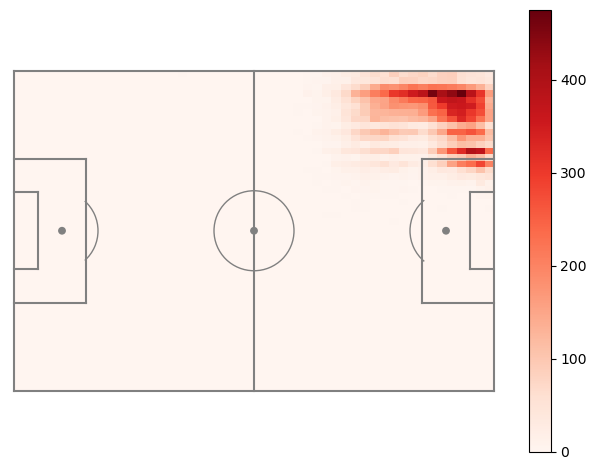

In [92]:
from FCPython import createPitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
pos=ax.imshow(H_Cross_start[0], extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
#ax.set_title('Danger passes per match by ' + team_required)
plt.xlim((-1,121))
plt.ylim((83,-3))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#fig.savefig('Output/HeatmapOfPasses' + team_required + '.pdf', dpi=None, bbox_inches="tight") 

In [9]:
def P2Gangle(x,y):
    #x distance from endline to point
    #y distance from point to centrline of pitch 
    a = 11
    b = np.sqrt((x-11)**2+y**2)
    c = np.sqrt(x**2 + y**2)
    theta = np.arccos((a**2-b**2-c**2)/(-2*b*c))
    return(np.degrees(theta))

In [8]:
x=27
y=21
a = 11
b = np.sqrt((x-11)**2+y**2)
c = np.sqrt(x**2 + y**2)
theta = np.arccos((a**2-b**2-c**2)/(-2*b*c))
P2Gangle(x,y)

14.821068070918363

In [117]:
train

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

In [119]:
train['subEventName']

0                    Simple pass
1                    Simple pass
2                    Simple pass
3                      High pass
4          Ground defending duel
                   ...          
3251289    Ball out of the field
3251290                   Corner
3251291                 Air duel
3251292                 Air duel
3251293                     Shot
Name: subEventName, Length: 3251294, dtype: object

In [16]:
#only gonna look at successful crosses now
#location of orignal cross
#create empty data frame
#create empty data frame
cross=train[train['subEventId']==80]
cross_model = pd.DataFrame(columns=['Successful'])

for i,cr in cross.iterrows():
    #match id
    
    #print(x1)
    cross_model.at[i,'matchId']=cr['matchId']
    #time of event
    cross_model.at[i,'matchPeriod'] = cr['matchPeriod']
    cross_model.at[i,'Sec']=cr['eventSec']
    #sorting out start start Y coordinates
    c = abs(cr['positions'][0]['y'] - 50)
    if cr['positions'][0]['y'] < 50:
        y = cr['positions'][0]['y'] + (2*c)
    else:
        y = cr['positions'][0]['y']
    #distance from attacking goal endline
    cross_model.at[i,'X1']=100-cr['positions'][0]['x']
    cross_model.at[i,'Y1']=y
    cross_model.at[i,'C1']=c#distance from centre line
    
    #sort out end y coordinates
    y1 = cr['positions'][1]['y']
    c1 = abs(y1 - 50)
    if y1 < 50:
        
        y1 = y1 + (2*c1)
    else:
        y1 = y1
    #distance from attacking goal endline
    x1 =cr['positions'][1]['x']
    cross_model.at[i,'X2']=100-x1
    cross_model.at[i,'Y2']=y1
    cross_model.at[i,'C2']=c1
    #get xG of end location
    
    
    #distance from goal
    x=cross_model.at[i,'X1']*105/100
    y=cross_model.at[i,'C1']*65/100
        #Euciledean Distance
    cross_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
    
    #angle peno spot to 6 yard box
    cross_model.at[i,'Angle'] = P2Gangle(x,y)
    
    #corner?
    cross_model.at[i,'Corner']=0
    if cr['eventId']==3:
        cross_model.at['Corner']=1
    #high or low
    cross_model.at[i,'Goal']=0
    cross_model.at[i,'Successful']=0
    cross_model.at[i,'high']=0
    cross_model.at[i,'inverted']=0
    cross_model.at[i,'xG']=0
    
    
    for tags in cr['tags']:
        if tags['id'] == 1801:
            cross_model.at[i,'Successful']=1
            
            x=100-x1#use .at to access single value, similar to .loc
        #y coordinate unchanged
            y=c1#2 dictionary within a list, keys = 'x','y'
        #to get the distance shot to the center line
          #  c=abs(cr['positions'][1]['y']-50)
            x=x*105/100
            y=y*65/100
        #Euciledean Distance
            print('yes ')
        
            s=np.sqrt(x**2 + y**2)
        #angle
            a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
            #print(s)
            #print(a)
            #print(xG(a=a,d=s))
            cross_model.at[i,'xG'] = xG(a=a,d=s)
            
        if tags['id'] == 301:
            cross_model.at[i,'Goal']=1
        
        if tags['id'] == 801:
            cross_model.at[i,'high']=1
        if tags['id'] == 802:
            cross_model.at[i,'high']=2
            #https://dataglossary.wyscout.com/pitch_coordinates/ needed to understand where is left and right flank
        if ((cr['positions'][0]['y']-50) < 0) and (tags['id'] == 402):
            cross_model.at[i,'inverted']=1
        if ((cr['positions'][0]['y']-50) > 0) and (tags['id'] == 401):
            cross_model.at[i,'inverted']=1
            
            
        

yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
23.581030511833024
0.20933735167691192
0.03566462068291764
yes 
34.736508172238615
0.15966287851418706
0.009650395453476419
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
30.96066052266973
0.16122629533593327
0.014779188884672714
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
16.071792059381554
0.2752793134772887
0.08653089574422197
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
17.85
0.40447783762626216
0.08400018578911617
yes 
31.87259794870823
0.1745484415296662
0.01357523391070935
yes 
23.1
0.31427070504979715
0.0429134444993414
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
26.095258189947078
0.1259772914

yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
13.368619973654724
0.3560705838299028
0.12529530464600788
yes 
31.526813984289628
0.23095892231160217
0.015181164487741037
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
15.96316071459534
0.4455153283895856
0.10709904905578471
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
26.1901221837547
0.034272192601701085
0.0213738015840537
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
29.80805260328155
0.07014673002718448
0.014946037513887357
yes 
4.9396356140913875
1.2270686920947695
0.5398333111319782
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
6.432728814

yes 
11.55
0.6137460607827115
0.19815699786545082
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
12.6
0.5653932311874568
0.17068479254066193
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
16.072958657322552
0.413920005768173
0.10204371163088265
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
16.346635739503096
0.4009753589018125
0.09771736650563041
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
12.527270253331329
0.10668777772811995
0.10199915712563057
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
15.039697470361562
0.314295685

yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
12.616754733290174
0.5640811317617371
0.17017168950667824
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
17.160492417177313
0.34153966032468785
0.08367072710519446
yes 
7.201562330494682
0.6742728322518933
0.3049454795045528
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
10.505831713862543
0.37729531977152453
0.1694131200284538
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
24.381345327934635
0.2831878014924241
0.035872486416038234
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
14.052135069091813
0.3

yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
16.05381574579701
0.3881962225284794
0.09918242588033037
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
81.45061387122874
0.08684741800088644
4.367521798894385e-05
yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
10.24621881476284
0.24662882664554397
0.15033775715294284
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
11.55
0.6137460607827115
0.19815699786545082
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
31.07752403265099
0.08052544966689454
0.013138696456590302
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
23.134444017525038
0.058850312818993354
0.030941602545214553
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
17.03855921138873

yes 
15.592626462530292
0.4380367459389602
0.1102280779258234
yes 
5.25
1.2176116877221752
0.5279592701498024
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
15.243113199081087
0.33759032764216496
0.1015019426651993
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
yes 
9.948115399411085
0.4221128427487011
0.18732482548135382
yes 
7.860343503944341
0.6711834202118175
0.28846973043978863
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
20.83920583899492
0.1271435315299231
0.04337632147244222
yes 
15.542281042369552
0.3548588071854964
0.10047332348513302
yes 
25.371736243308224
0.012193020196023035
0.0227554241364322
yes 
7.813129974600448
0.45069259319868493
0.23376674449241877
yes 
4.2
1.4336073198863475
0.626012740552631
yes 
20.052929960482086
0.2329605153822246
0.053908352288657445
yes 
26.705476966345316
0.08764166390331081
0.02161610544291636
yes 
11.114180131705622
0.56083

yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
33.22085188552515
0.10535682551435806
0.010665019975599883
yes 
82.80368349294613
0.08515544937227128
3.7363856059267244e-05
yes 
4.9396356140913875
1.2270686920947695
0.5398333111319782
yes 
32.5
0.0
0.010085468321541396
yes 
82.80368349294613
0.08515544937227128
3.7363856059267244e-05
yes 
19.106281689538655
0.3364137577148097
0.06776866221195034
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
21.011663427725086
0.17764718360137735
0.045357996006910706
yes 
23.61106732022083
0.04235391586814576
0.028745823696376974
yes 
14.928161306738348
0.47457492357511266
0.1229433195059443
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
8.355387483534201
0.5979823340415903
0.25820876190511893
yes 
13.168523075880605
0.09577245576542756
0.09427955990722353
yes 
17.68629412850527
0.22705100397193015
0.06890043940024436
yes 
11.747020898934332
0

yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
28.651221614444296
0.05704784950558044
0.01672613338509539
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
6.3
1.0525922912360763
0.4441679612144381
yes 
18.891929493834134
0.24132760305939444
0.06168523964491049
yes 
11.19933033712284
0.44772227561121114
0.1713460896206024
yes 
19.784653143282544
0.35082550307332194
0.06418282701601251
yes 
9.018037480516478
0.3272370360387149
0.18446508554219165
yes 
15.93180780702554
0.3663043742089903
0.09785998993029967
yes 
16.909316958410827
0.3008128276935503
0.08177761405534303
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
14.71436373072244
0.48717423374771535
0.12741811761979133
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
17.288724649319857
0.3604273826581395
0.08445880361864275
yes 
12.616754733290174
0

yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
19.936524270795047
0.21667629414887685
0.05349372726422448
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
30.45693681248986
0.23913994080948214
0.017293236883668482
yes 
17.740913167027227
0.24973250444438694
0.07042932064742932
yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
17.897276329095444
0.4024840245835908
0.08338701657167628
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
22.715028065137847
0.07631739769929179
0.03313141895161874
yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
6

yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
17.077031357938065
0.13725497626031505
0.06584083930060756
yes 
14.052135069091813
0.35947975315199954
0.11748579032857552
yes 
10.540042694410682
0.44102340262668716
0.18094621481844309
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
38.43478242425733
0.12018147414356417
0.00603892482312016
yes 
7.223053370978232
0.536463366670397
0.2674949628955401
yes 
7.223053370978232
0.536463366670397
0.2674949628955401
yes 
2.198294793698061
-1.0625502407498768
0.07330847575728999
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
8.707037383633999
0.24147391818800512
0.17311577685823537
yes 
32.05035101211842
0.20190227402910502
0.013787461318289692
yes 
36.26034335193201
0.12920533722082628
0.0078111926892604775
yes 
12.735089320456296
0.34697519319792164
0.1320305271286514
yes 
7.088899773589692
0.8965302427131067
0.37308111516978

yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
6.079679267856159
0.7744838280818499
0.3624795977854992
yes 
28.45
0.10581592952933622
0.01821803120292103
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
18.873857581321314
0.3244111338463662
0.06844517361441298
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
6.192132104533947
0.8891188201608188
0.3948940772419724
yes 
33.26924255224

yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
11.490213226916202
0.1919763125065986
0.1250755394393097
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
17.956196701974505
0.4000177485012383
0.08263037524142848
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
13.65
0.5239396375264456
0.14746223295105995
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
92.965047195169
0.07645146760784419
1.1632749669270719e-05
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
18.80452073305778
0.22218647880062012


yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
14.71436373072244
0.48717423374771535
0.12741811761979133
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
18.798005213319843
0.20073106469545723
0.05926177490797288
yes 
15.803559725580817
0.45382332870968084
0.10991035566051277
yes 
20.508047201037936
0.25835749013039877
0.05297842482854703
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
3.15
-1.4212956654322835
0.04243086567381814
yes 
9.811855074347562
0.5757983344575113
0.22268889944167608
yes 
23.3
0.14415052081001242
0.033863327789348495
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
24.634630096674883
0.11603507253881526
0.02820413656140351
yes 
13.36861997365472

yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
26.16027522790997
0.22521634946408495
0.027392601284102782
yes 
27.018928550184963
0.07493614214016456
0.020536513590018454
yes 
58.159543498896205
0.12032464087858749
0.000644606311326316
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
34.314319168533714
0.16359127234690427
0.010172027274782143
yes 
18.78776197422141
0.30686081917077107
0.06760394531142941
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
18.80452073305778
0.22218647880062012
0.06081071928404262
yes 
17.834937622543006
0.174778131730866
0.06360842903151775
yes 
6.333442981506978
1.045705620550453
0.44099751683

yes 
17.58138219822321
0.025985883067351015
0.05437435307403343
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
31.270593214712125
0.015937195694941196
0.01182335393847036
yes 
33.421549934136806
0.13839858275896094
0.010884494788670769
yes 
12.210036854981233
0.377492841312113
0.14389349815123031
yes 
25.07334241779504
0.26820128002129745
0.03262106063133601
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
y

yes 
12.431009613060397
0.21448423646990336
0.11684770202159454
yes 
35.382552197375475
0.10510890238137988
0.008357521148135861
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
11.65
0.3043948372634069
0.1399527810803216
yes 
15.243113199081087
0.33759032764216496
0.1015019426651993
yes 
3.4077118422777475
-1.493618846981308
0.037656984399188076
yes 
9.018037480516478
0.3272370360387149
0.18446508554219165
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
6.079679267856159
0.7744838280818499
0.3624795977854992
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
28.26380193816819
0.03912207618077919
0.017066671049396097
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
12.6665

yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
22.392241960107523
0.31941343087727586
0.046642801866180035
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
20.21299087220889
0.35398215152994544
0.06155783711121128
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
21.733154395991395
0.10014877740411239
0.03802964769148052
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
31.07752403265099
0.08052544966689454
0.013138696456590302
yes 
58.85745492288976
0.12408833122678112
0.0005984064545527834
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
yes 
5.4085

yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
23.64254639415983
0.11222965318467674
0.031314302933682224
yes 
18.85
0.28430431212281077
0.06532612571598143
yes 
8.077747210701755
0.28819254085029083
0.19297991214595273
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
15.75
0.4566570735017896
0.11087410763401144
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
18.31843333912592
0.11872408711443082
0.056363638479302924
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
16.071792059381554
0.2752793134772887
0.08653089574422197
yes 
15.115058716392735
0.37455292140405577
0.10740559817964773
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
30.512374538865373
0.23829209884521543
0.017167625797943634
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
15.9318078

yes 
11.073617295175051
0.33830271298288245
0.15373673376778518
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
17.740913167027227
0.24973250444438694
0.07042932064742932
yes 
14.3287298809071
0.380925130447818
0.11714665588698783
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
23.134444017525038
0.058850312818993354
0.030941602545214553
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
65.33272533730702
0.09902476523508885
0.0002773677722706436
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
28.438793926606664
0.04827962484595624
0.016935206655792047
yes 
16.58463143998081
0.

yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
17.880855684222723
0.2692928913160728
0.07107278769221514
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
4.526035793053342
1.272510127702622
0.5662110012870131
yes 
15.821267332296738
0.42632836199012014
0.10623432063700512
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 


yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
30.658807869843862
0.09921482211740264
0.014108086151058852
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
9.629771544538322
0.2828421327364761
0.16599576942998417
yes 
16.071792059381554
0.2752793134772887
0.08653089574422197
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
12.86944054728099
0.3838839963626258
0.13588392171611766
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
14

yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
26.006201183563892
0.13824105513429696
0.02492933619409449
yes 
16.758952831248138
0.33206626567067177
0.08625260911401834
yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
1.2349089035228469
-0.5746030705476068
0.14352938341995852
yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
15.550723455839602
0.29404598468395515
0.09339757177234911
yes 
14.7
0.4880360972577503
0.1277259365575217
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
7.813129974600448
0.45069259319868493
0.23376674449241877
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 


yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
10.866577197995698
0.2167952219106215
0.13685093738249327
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
12.719768079646736
0.3012999905051857
0.1254947903530597
yes 
3.2163644072150777
-1.439259081683013
0.0411831654160122
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
31.247479898385404
0.15049677605802889
0.014114214268893135
yes 
16.55249225947561
0.08825418137151914
0.0655501490180314
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
16.641213898030394
0.3876504547249745
0.09331169974645144
yes 

yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
12.159358535712318
0.3304128075433245
0.13712022579948596
yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
23.036112953360856
0.1183157404420048
0.03373474894283288
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
64.73503688112025
0.10085529896630158
0.0002975831249219109
yes 
77.19601673661667
0.08895887537398679
7.104592341070106e-05
yes 
11.247777558255676
0.1350674206438104
0.12000058156570004
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
9.553140844769327
0.6684012104010006
0.24993204882248

yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
13.895412912180769
0.5074894297819179
0.1413447208399294
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
4.55
0.0
0.19650665566456155
yes 
17.740913167027227
0.24973250444438694
0.07042932064742932
yes 
12.86944054728099
0.3838839963626258
0.13588392171611766
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
35.95622338344226
0.1549366585523267

yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
15.87025519643588
0.45032685635196196
0.10872461842350331
yes 
12.6
0.5653932311874568
0.17068479254066193
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
8.85889383614004
0.44130133603682115
0.2110816265775779
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
2.86574597618142
-1.2455895851739884
0.05450903601810482
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
17.97811169172113
0.3119750682558491
0.07410315324023878
yes 
14.85075755643462
0.44942616

yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
15.635296607356063
0.033250834273230806
0.06753942038343387
yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
5.013232490120521
1.0999616478160181
0.49607415967641716
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
15.20855022676389
0.45868567606362104
0.11736648092363468
yes 
35.37258825701054
0.11130512875002672
0.008434734745056648
yes 
26.378447641967107
0.2744626900813109
0.02847580450293672
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
8.412044935685971
0.38217689414903444
0.20664151452912213
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
8.355387483534201
0.5979823340415903
0.25820876190511893


yes 
13.578107379160027
0.3844644915514975
0.1267807655204638
yes 
34.82287323010552
0.10852619741526776
0.008941514600923347
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
47.859429582894116
0.12424292745649981
0.002087223464470587
yes 
26.194131022043848
0.2462482602502879
0.028033436311663048
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
15.984523765192382
0.33596709169430355
0.09388576051427994
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
29.80805260328155
0.07014673002718448
0.014946037513887357
yes 
24.25123708184801
0.10658105396975748
0.029071277560548184
yes 
16.641213898030394
0.3876504547249745
0.09331169974645144
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
7.464080653369174
0.9043227873413638
0.365529173879

yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
14.778700890132395
0.35868342997638314
0.1090848627167002
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
5.600446410

yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
14.281544034172217
0.15995098636097377
0.09073398656398206
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
24.255411767273714
0.04008431153607083
0.02669172041487098
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
ye

yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
20.83920583899492
0.1271435315299231
0.04337632147244222
yes 
17.575622321841124
0.371980340303136
0.08311966063137738
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
26.121112150901997
0.06883238564869486
0.022516616211931687
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
24.23324163210527
0.08018952213907987
0.028164286319433112


yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
20.47266470198738
0.2942936663002349
0.05560890512243185
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
12.74539132392568
0.15348370408474826
0.10540848359119705
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
22.401785643113364
0.3049000780893932
0.04575473627138994
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
27.446766658388015
0.19485780930602808
0.0228456192107332
yes 
29.0452233

yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
29.249615382086652
0.091014859437489
0.01634536511873207
yes 
16.60195771588399
0.2579165948692716
0.08018418336827897
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
18.78776197422141
0.30686081917077107
0.06760394531142941
yes 
17.22128044019956
0.26503529037733264
0.07579382791895159
yes 
17.14037630858786
0.2418706622612818
0.07431957813303454
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
33.

yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
31.517495141587634
0.11710970372296038
0.01311328393743828
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
7.226686654338903
0.19541669871882594
0.18909747840310423
yes 
32.91944713995058
0.0716889538458223
0.010560408316651339
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
17.68629412850527
0.22705100397193015
0.06890043940024436
yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
24.92533851324792
0.22378029756517134
0.031335482201703034
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
16.078323917622757
0.21606882460132645
0.080521111716053
yes 


yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
16.77453427073312
0.3568783542073093
0.0887135256554184
yes 
23.216588896735026
0.1737061697838798
0.035480235630627584
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
23.127743080551546
0.2730351404249318
0.0406193658965447
yes 
24.379550857224586
0.2709888852947542
0.035329199285651106
yes 
23.853982895944235
0.28271739483462277
0.037982628887583726
yes 
22.228360263411243
0.280229343638815
0.04520366679489192
yes 
27.167995877502634
0.22922448282251776
0.024625687975227663
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
24.413981649866127
0.052717202254373124
0.026654520136868493
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
20.49243762952568
0.11295129655902525
0.04424700133412887
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
7.40

yes 
83.98979104629323
0.08385788447020512
3.259402709973929e-05
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
10.540042694410682
0.44102340262668716
0.18094621481844309
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
17.077031357938065
0.13725497626031505
0.06584083930060756
yes 
17.97811169172113
0.3119750682558491
0.07410315324023878
yes 
17.64319982316133
0.30025973949935153
0.07567512737373278
yes 
6.079679267856159
0.7744838280818499
0.3624795977854992
yes 
61.60491051856175
0.11131890100258167
0.0004306267057781053
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
21.857321427841974
0.06611262865644796
0.035934649471473276
yes 
21.22227603250886
0.22478665008704846
0.04703158453403677
yes 
40.04001123875966
0.13929398689069267
0.005163859213492743
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
12.253

yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
14.446106741956465
0.23188804892968712
0.09718510760540448
yes 
18.879221382249852
0.022402494251389304
0.047054899744066736
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
57.457919384537405
0.12326359586655476
0.0007008039044260996
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
16.15549442140351
0.12353355056467187
0.07138242206582612
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
15.740711546813886
0.06549356410585784
0.0694778078419076
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
17.834937622543006
0.174778131730866
0.06360842903151775
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
2

yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
5.2900850654786264
1.2079676869865599
0.5236634145958382
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
18.006943105369107
0.33324589215754935
0.07581364786275326
yes 
22.20275883758593
0.3246572898667033
0.047923718918676736
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
15.93180780702554
0.3663043742089903
0.09785998993029967

yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
16.80133923233502
0.4050541670933145
0.09370658929258942
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
16.80133923233502
0.4050541670933145
0.09370658929258942
yes 
20.790021645010377
0.3354910763529341
0.05656404885047906
yes 
23.64254639415983
0.11222965318467674
0.031314302933682224
yes 
30.46653902234384
0.08382018694578963
0.014130862271989036
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
31.969047530384763
0.16610153904273486
0.013282900292085318
yes 
4.25
1.4201477008546248
0.6205253695370736
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
15.93180780702554
0.3663043742089903
0.09785998993029967
yes 
17.897276329095444
0.4024840245835908
0.08338701657167628
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
10.58017

yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
41.77514213021902
0.1280052584656664
0.004180932222599935
yes 
16.641213898030394
0.3876504547249745
0.09331169974645144
yes 
19.312237053226124
0.0852954108562007
0.04857526560856979
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
27.438522190526225
0.10356645744265197
0.02033442795243403
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
27.51567734946752
0.22356025782715727
0.023522162651892935
yes 
4.25
1.4201477008546248
0.6205253695370736
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
19.479797226870

yes 
14.53977303811858
0.3360930094197185
0.10884090676834092
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
70.64964614207207
0.103081384406135
0.00015235322511452293
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
7.223053370978232
0.536463366670397
0.2674949628955401
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
13.583997938751317
0.458874034466134
0.13792524618028934
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
13.4

yes 
19.45668265660927
0.16681842844857084
0.052942274001669516
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
6.3
1.0525922912360763
0.4441679612144381
yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
14.928161306738348
0.47457492357511266
0.1229433195059443
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
27.267058880634707
0.11528756584889072
0.021041388104111054
yes 
6.192132104533947
0.8891188201608188
0.3948940772419724
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
18.31843333912592
0.11872408711443082
0.056363638479302924
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
17.22128044019956
0.26503529037733264
0.07579382791895159
yes 
29.285662020859288
0.05456911607042257
0.01553021661804359
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
17.22128044019956
0.26503529037733264
0.07579382791895159
yes 
14.85075755643462
0.4494261620364326
0

yes 
13.168523075880605
0.09577245576542756
0.09427955990722353
yes 
16.60195771588399
0.2579165948692716
0.08018418336827897
yes 
7.738862965578341
0.5842369076531417
0.26830224994000906
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
27.018928550184963
0.07493614214016456
0.020536513590018454
yes 
17.22128044019956
0.26503529037733264
0.07579382791895159
yes 
35.48552521803784
0.14095512315473027
0.00865597711129674
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
yes 
30.52232789287213
0.10839094164989209
0.014496825440213596
yes 


yes 
17.24673882216577
0.40856918354554417
0.08986998236301474
yes 
39.60230422589069
0.1180785676207688
0.005277578678235407
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
13.895412912180769
0.5074894297819179
0.1413447208399294
yes 
13.895412912180769
0.5074894297819179
0.1413447208399294
yes 
25.046406927940783
0.24534391562807015
0.0317806308102303
yes 
19.026954564511893
0.1531164188492157
0.054511203868196495
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
18.268894328885914
0.235469255366503
0.0654430960235815
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 


yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
13.864072273325755
0.2523954192191739
0.10566837158457626
yes 
17.86183081321733
0.40397763645873547
0.08384623174889909
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
27.24596300371855
0.16712994651079055
0.022544023866155845
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
26.378447641967107
0.2744626900813109
0.02847580450293672
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
15.96316071459534
0.4455153283895856
0.10709904905578471
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes

yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
32.73610392212244
0.10133215069616862
0.011203856567130188
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
10.60990103629624
0.1537759850257076
0.13064030384064465
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
25.47474239320194
0.0964449775304317
0.025063799844955992
yes 
31.690061533547073
0.07741362120359095
0.012216099815504072
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
32.156647835245515
0.1050384675890873
0.012015502973391498
yes 
26.39403341666446
0.07858215339107469
0.02211898044363761
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
17.28872

yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
23.613661300188078
0.28832362510707366
0.039270847154972324
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
14.37167352815948
0.27166474021544557
0.1026451623830415
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
5.25
1.2176116877221752
0.5279592701498024
yes 
19.199283840810313
0.2941379108771195
0.06370885083059011
yes 
11.073617295175051
0.33830271298288245
0.15373673376778518
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
18.798005213319843
0.20073106469545723
0.05926177490797288
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
13.419575

yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
30.23722870899382
0.21828520037858615
0.017252198322638815
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
14.453373308677806
0.0784659529811174
0.08081623013648316
yes 
6.3
1.0525922912360763
0.4441679612144381
yes 
14.37167352815948
0.27166474021544557
0.1026451623830415
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
12.616754733290174
0.5640811317617371
0.17017168950667824
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
12.86545762886031
0.5

yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
29.285662020859288
0.05456911607042257
0.01553021661804359
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
36.059014129618134
0.17729929739066996
0.008507431655312134
yes 
21.724007457188925
0.21455222164946441
0.04397081536590978
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
18.57639631360184
0.2712176259591417
0.06618105949101327
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
36.47807560713695
0.10464390535690224
0.007381380155157466
yes 
30.635681810594654
0.18880458219824617
0.015883607785694764
yes 
15.740711546813886
0.06549356410585784
0.0694778078419076
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
y

yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
13.271209439986997
0.3193088176827172
0.12127219347341044
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
15.87025519643588
0.45032685635196196
0.10872461842350331
yes 
28.45
0.10581592952933622
0.01821803120292103
yes 
5.73149195236284
1.006617039996295
0.4452147733000501
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
10.022474744293447
0.3394858385348591
0.17015814926929432
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
13.880291783676595
0.33042245113400326
0.11556709753949135
yes 
11.19933033712284
0.44772227561121114
0.1713460896206024
yes 
4.08442162

yes 
27.644981461379206
0.0715325896138029
0.01906855041285876
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
17.956196701974505
0.4000177485012383
0.08263037524142848
yes 
3.2163644072150777
-1.439259081683013
0.0411831654160122
yes 
29.184970447132546
0.07321150645230452
0.016089445922678938
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
28.275873107651336
0.08776709216772068
0.018148154542043306
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
4.25
1.420147

yes 
6.215504806530198
0.547089724414486
0.29341881720626006
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
4.9396356140913875
1.2270686920947695
0.5398333111319782
yes 
11.067971810589327
0.39990201971111766
0.1646523990843763
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
4.9396356140913875
1.2270686920947695
0.5398333111319782
yes 
30.06742423288034
0.10318751653457633
0.015152348061183036
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
3.4077118422777475
-1.493618846981308
0.037656984399188076
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
9.26120942425988
0.70425144

yes 
13.65
0.5239396375264456
0.14746223295105995
yes 
17.0
0.4196933376909174
0.09342199689602473
yes 
32.446417367715654
0.08850616859272875
0.011383501684640255
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
27.85722527460336
0.11041033747046444
0.01957917835914251
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
20.562648175757907
0.22157235236141123
0.050307787966158556
yes 
22.939267643061317
0.263508463991348
0.0409681960911287
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
74.32598805263204
0.09731892518574166
9.954790411936725e-05
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
15.542522317822161
0.

yes 
15.542281042369552
0.3548588071854964
0.10047332348513302
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
11.067971810589327
0.39990201971111766
0.1646523990843763
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
10.24621881476284
0.24662882664554397
0.15033775715294284
yes 
12.86944054728099
0.3838839963626258
0.13588392171611766
yes 
16.15549442140351
0.12353355056467187
0.07138242206582612
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
18.87246671741667
0.17749551952038806
0.05712473105109756
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 

yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
14.00874726733265
0.12544164251742995
0.08955933252513656
yes 
13.894603268895446
0.40423785554982494
0.12567681952176035
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
27.323250172700902
0.08367079002604733
0.020076411324375557
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
9.436233358708336
0.3860238918624772
0.1889729334856761
yes 
6.192132104533947
0.8891188201608188
0.3948940772419724
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
10.866577197995698
0.2167952219106215
0.13685093738249327
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
10.488326844640

yes 
12.719768079646736
0.3012999905051857
0.1254947903530597
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
21.705874780805313
0.2780501185162574
0.04770810638257245
yes 
7.201562330494682
0.6742728322518933
0.3049454795045528
yes 
96.72497092271469
0.07227216100922884
7.544273521777042e-06
yes 
24.936168510819783
0.1380764132665549
0.02805846070467865
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
96.72497092271469
0.07227216100922884
7.544273521777042e-06
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
19.612750954417386
0.041380818638383214
0.04450118466253709
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
27.004490367344463
0.20124039128196763
0.024192868558606456
yes 
16.955603793436552
0.37409046709081273
0.08887739320817523
yes 
15.721402609182173
0.40392351097823914
0.10452

yes 
31.978195696442913
0.06843572336682689
0.011689919356464023
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
12.616754733290174
0.5640811317617371
0.17017168950667824
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
15.542281042369552
0.3548588071854964
0.10047332348513302
yes 
73.49506786172797
0.09811035816170081
0.00010952517835338452
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
13.583997938751317
0.458874034466134
0.13792524618028934
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
31.829703108888715
0.04609557589912188
0.011546753391621367
yes 
9.529559276272959
0.5372398447113629
0.21949243528893

yes 
13.578107379160027
0.3844644915514975
0.1267807655204638
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
14.778700890132395
0.35868342997638314
0.1090848627167002
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
18.10414317221337
0.28538343785592213
0.07079277112127565
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
15.763406992144814
0.4559455575313209
0.11063188939568547
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
24.141509894784956
0.026989482279809688
0.026581443935165906
yes 
15.75
0.4566570735017896
0.11087410763401144
yes 
17.22128044019956
0.

yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
11.914801718870523
0.44610227378018025
0.15981524683572734
yes 
18.78416886636191
0.3674420847340529
0.07282488120854526
yes 
8.707037383633999
0.24147391818800512
0.17311577685823537
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
17.696680479683188
0.12749992296548607
0.06090020149476964
yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
14.642831010429644
0.11420761785985901
0.08272459862664872
yes 
5.40855803333938

yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
19.42427604828556
0.325884155321079
0.06467763458042033
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
78.95379978189776
0.08750571764267637
5.806419005842314e-05
yes 
26.57668150842012
0.1323276028143828
0.023223235192893106
yes 
5.013232490120521
1.0999616478160181
0.49607415967641716
yes 
6.3
1.0525922912360763
0.4441679612144381
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
6.333442981506978
1.04570562

yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
15.503064213245072
0.23276899026498218
0.08723034183109218
yes 
25.49078264785136
0.07233918821756793
0.024258180353681606
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
17.22128044019956
0.26503529037733264
0.07579382791895159
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
17.64319982316133
0.30025973949935153
0.07567512737373278
yes 
20.04507420789457
0.3596291964810334
0.06310742241681921
yes 
37.60069813181665
0.1471152692180115
0.006873133879850787
yes 
14.3287298809071
0.380925130447818
0.11714665588698783
yes 
31.447813914483785
0.08644724542918653
0.012700984537900452
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
15.542281042369552
0.3548588071854964
0.10047332348513302
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
11.914801718870523
0.44610227378018025
0.1598152468357273

yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
75.47516147713763
0.08902443847693159
8.640790375323168e-05
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
12.86944054728099
0.3838839963626258
0.13588392171611766
yes 
16.58463143998081
0.23080912089374037
0.07773739537209633
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
9.018037480516478
0.3272370360387149
0.18446508554219165
yes 
5.013232490120521
1.0999616478160181
0.49607415967641716
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
10.5801701

yes 
5.25
1.2176116877221752
0.5279592701498024
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
15.477725931156682
0.2654567711126684
0.09094906867764593
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
17.956196701974505
0.4000177485012383
0.08263037524142848
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
8.793179174792243
0.76

yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
7.20

yes 
17.19447585708852
0.3158311044591509
0.08082951098115744
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
12.6
0.5653932311874568
0.17068479254066193
yes 
14.44610674

yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
6.64417037710503
0.6434168091363027
0.3098080184452543
yes 
15.984523765192382
0.33596709169430355
0.09388576051427994
yes 
32.10763149159402
0.1939298730862372
0.013558361038148373
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
13.880291783676595
0.33042245113400326
0.11556709753949135
yes 
15.528763633979365
0.13418083006105208
0.07724446760410567
yes 
29.717419134238423
0.04415743425768069
0.01459905893350211
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
16.80133923233502
0.4050541670933145
0.09370658929258942
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
14.403124660989365
0.3068516613729326
0.10664128356100076
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292


yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
18.14345612059621
0.39231452383640797
0.08028005107229846
yes 
22.715028065137847
0.07631739769929179
0.03313141895161874
yes 
43.05
0.16962694226474803
0.003821394781282572
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
30.635681810594654
0.18880458219824617
0.015883607785694764
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
32.125729

yes 
13.583997938751317
0.458874034466134
0.13792524618028934
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
21.830769569577704
0.13197821508944838
0.03916960791318185
yes 
14.778700890132395
0.35868342997638314
0.1090848627167002
yes 
13.578107379160027
0.3844644915514975
0.1267807655204638
yes 
5.858540773947041
1.07215014489556
0.4629761354655894
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
13.419575254083117
0.22658931818991998
0.10725104354632273
yes 
16.078323917622757
0.21606882460132645
0.080521111716053
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
21.646304534492717
0.2638775631713452
0.0471727242324874
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
15.763406992144814
0.4559455575313209
0.11063188939568547
ye

yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
15.096771177970473
0.07153641132308428
0.07491197987575803
yes 
60.53786005467983
0.11940991202638283
0.0004913457769348527
yes 
12.159358535712318
0.3304128075433245
0.13712022579948596
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
29.717419134238423
0.04415743425768069
0.01459905893350211
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
12.735089320456296
0.34697519319792164
0.1320305271286514
yes 
9.529559276272959
0.5372398447113629
0.219492435

yes 
30.535593984725434
0.20611073933091856
0.01642584963220306
yes 
29.857201811288345
0.08731164361814467
0.01519786156946351
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
16.223208683857827
0.1825584951951526
0.07615369159636698
yes 
32.31098884280702
0.059591438390193784
0.011132047080275735
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
31.192827701252096
0.04802073334988022
0.012434263815808677
yes 
11.067971810589327
0.39990201971111766
0.1646523990843763
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
20.207238801973908
0.33694567230348166
0.06031441122255827
yes 
21.232286735064594
0.1396564151140516
0.04221880295831056
yes 
39.5170849127311
0.15754619738517855
0.005610722932201409
yes 
17.575622321841124
0.371980340303136
0.08311966063137738
yes 
14.757371039585607
0.48460536525591696
0.1265019

yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
19.312237053226124
0.0852954108562007
0.04857526560856979
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
4.2
1

yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
57.148250191935006
0.12459478576143639
0.000727172613825336
yes 
58.17121281183675
0.1225235783005695
0.0006456134850393115
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
yes 
13.880291783676595
0.33042245113400326
0.11556709753949135
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
11.55
0.6137460607827115
0.19815699786545082
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
8.644362324659928
0.

yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
13.894603268895446
0.40423785554982494
0.12567681952176035
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
14.642831010429644
0.11420761785985901
0.08272459862664872
yes 
31.829703108888715
0.04609557589912188
0.011546753391621367
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
7.3893504450661975
0.75

yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
18.891929493834134
0.24132760305939444
0.06168523964491049
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
17.575622321841124
0.371980340303136
0.08311966063137738
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
16.078323917622757
0.21606882460132645
0.080521111716053
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
12.23376475170256
0.2748761318721257
0.12776703222251387
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 


yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
yes 
15.93180780702554
0.3663043742089903
0.09785998993029967
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
14.935946571945147
0.2852409034330836
0.09845590311769269
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
16.078323917622757
0.21606882460132645
0.080521111716053
yes 
41.03245666542524
0.17757441938710802
0.004852243873775981
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
17.880855684222723
0.2692928913160728
0.07107278769221514
yes 
17.428496779699618
0.1575096013680273
0.06502428558659713
yes 
15.550723455839602
0.29404598468395515
0.09339757177234911
yes 
4.25
1.4201477008546248
0.6205253695370736
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
17.71778767

yes 
14.778700890132395
0.35868342997638314
0.1090848627167002
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
13.661625086350451
0.17563183941533048
0.09853491714427896
yes 
13.578107379160027
0.3844644915514975
0.1267807655204638
yes 
20.562648175757907
0.22157235236141123
0.050307787966158556
yes 
17.562032911938186
0.32654703564538545
0.07879410155998037
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
19.30401512639275
0.2712737199954445
0.06125182913121091
yes 
19.298186443290465
0.36780864688627385
0.06900640157686118
yes 
6.830812543175226
0.43288350386023056
0.2499533716520841
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
7.738862965578341
0.5842369076531417
0.26830224994000906
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
15.11861435449691
0.4347254180747608
0.11518251755850

yes 
30.193542355940945
0.03421302857943059
0.013663110217415064
yes 
5.2900850654786264
1.2079676869865599
0.5236634145958382
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
35.382552197375475
0.10510890238137988
0.008357521148135861
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
15.115058716392735
0.37455292140405577
0.10740559817964773
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
23.182159088402443
0.3121359581023169
0.04241729186938028
yes 
32.73610392212244
0.10133215069616862
0.011203856567130188
yes 
17.956196701974505
0.4000177485012383
0.08263037524142848
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
6.215504806530198
0.547089724414486
0.29341881720626006
yes 
13.396361446303246
0.5069724665686698
0.148287395237321

yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
28.308700076125007
0.11651745911862918
0.018764804867204814
yes 
16.027554398597438
0.2473593957795706
0.0840614062697221
yes 
10.540042694410682
0.44102340262668716
0.18094621481844309
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
12.616754733290174
0.5640811317617371
0.17017168950667824
yes 
19.30401512639275
0.2712737199954445
0.06125182913121091
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
15.550723455839602
0.29404598468395515
0.09339757177234911
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
8.412044935685971
0.38217689414903444
0.2066415145291

yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
11.65
0.3043948372634069
0.1399527810803216
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
6.333442981506978
1.0457

yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
16.824089871371942
0.16938027510108197
0.07034286517644976
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
8.707037383633999
0.24147391818800512
0.17311577685823537
yes 
15.626259949200897
0.19722523191191269
0.08251612695487559
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
15.626259949200897
0.19722523191191269
0.08251612695487559
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
13.044634912484135
0.19365511520232903
0.10719005138094338
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
y

yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
15.542281042369552
0.3548588071854964
0.10047332348513302
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
21.342738812064397
0.2873574896602006
0.05019943016624235
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
17.696680479683188
0.12749992296548607
0.06090020149476964
yes 
13.044634912484135
0.19365511520232903
0.10719005138094338
yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
6.81

yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
11.914801718870523
0.44610227378018025
0.15981524683572734
yes 
10.616143367532297
0.30022768467042926
0.1539962502531497
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
21.45233087568808
0.08579915158979413
0.038511022574773394
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
yes 
16.071792059381554
0.2752793134772887
0.08653089574422197
yes 
13.419575254083117
0.22658931818991998
0.10725104354632273
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
13.894603268895446
0.40423785554982494
0.12567681952176

yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
16.027554398597438
0.2473593957795706
0.0840614062697221
yes 
36.780021750945174
0.15931626873117627
0.007661271472973817
yes 
9.40226036652889
0.4734809931229669
0.2078516204924168
yes 
21.010057115581574
0.34479076913151024
0.05588475354561478
yes 
15.96316071459534
0.4455153283895856
0.10709904905578471
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
17.14037630858786
0.2418706622612818
0.07431957813303454
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
13.271209439986997
0.3193088176827172
0.12127219347341044
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
4.630

yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
6.3
1.0525922912360763
0.4441679612144381
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
30.997822504169548
0.04053845556379962
0.012586752706766487
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
33.794563172202714
0.10179309892300134
0.009951959437570984
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
31.537636246237607
0.13238305126281544
0.013345349969875043
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
23.1
0.31427070

yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
19.45668265660927
0.16681842844857084
0.052942274001669516
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
73.03286931238564
0.0921940302862945
0.00011454107362096956
yes 
10.505831713862543
0.37729531977152453
0.1694131200284538
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
19.000328944520934
0.3787722941698328
0.07217308743596601
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
24.827806991355477
0.27338566993338587
0.03373507126683673
yes 
23.180271784429102
0.2988423003378373
0.04172205536514193
yes 
5.2900850654786264
1.2079676869865599
0.5236634145958382
yes

yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
18.189901044260797
0.3483365427834284
0.07574523252023682
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
15.720687007888682
0.3176837118199129
0.09439562076028025
yes 
59.165023451360184
0.11846522401484007
0.0005736001657328792
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
2.198294793698061
-1.0625502407498768
0.07330847575728999
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
12.823903461894899
0.24912252567008486
0.11693385981768933
yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
25.88793155120741
0.05844526875880115
0.022801577561608874
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
15.763406992144814
0.4559455575313209
0.11063188939568547
yes 
10.580170130957253
0.662397068973353
0.22729490604742977


yes 
37.03555723895619
0.1015084303627697
0.006902823759933469
yes 
16.77453427073312
0.3568783542073093
0.0887135256554184
yes 
33.7132392392069
0.11581093339124832
0.010228274796981136
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
23.1
0.31427070504979715
0.0429134444993414
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
24.862019226120793
0.1013311236298448
0.02699195316612974
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
13.28834075421006
0.2754185537241036
0.11506130843266184
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
8.036479328661276
0.810276

yes 
17.880855684222723
0.2692928913160728
0.07107278769221514
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
5.2900850654786264
1.2079676869865599
0.5236634145958382
yes 
15.115058716392735
0.37455292140405577
0.10740559817964773
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
30.2424370711092
0.09354015866873766
0.014673813701098454
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
7.860343503944341
0.6711834202118175
0.28846973043978863
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
11.55
0.6137460607827115
0.19815699786545082
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
20.850959210549522
0.28396321448134243
0.05271065986324533
yes 
7.860343503944341
0.6711834202118175
0.28846973043978863
yes 
9.9932477

yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
10.24621881476284
0.24662882664554397
0.15033775715294284
yes 
16.072958657322552
0.413920005768173
0.10204371163088265
yes 
5.25
1.2176116877221752
0.5279592701498024
yes 
32.08216015171048
0.11300549195875288
0.012242409189802607
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
16.909316958410827
0.3008128276935503
0.08177761405534303
yes 
31.07752403265099
0.08052544966689454
0.013138696456590302
yes 
24.03565060488274
0.12197157997214289
0.0303609703384296
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
12.431009613060397
0.21448423646990336
0.11684770202159454
yes 
13.253395791

yes 
7.201562330494682
0.6742728322518933
0.3049454795045528
yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
26.611369750540838
0.1644415192248432
0.024106905598082918
yes 
15.592626462530292
0.4380367459389602
0.1102280779258234
yes 
24.318717071424636
0.15823569381528604
0.030819404953268837
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
16.072958657322552
0.413920005768173
0.10204371163088265
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
16.955603793436552
0.37409046709081273
0.08887739320817523
yes 
21.830769569577704
0.13197821508944838
0.03916960791318185
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
13.788582233137678
0.5145691046572908
0.1439681045027769

yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
15.243113199081087
0.33759032764216496
0.1015019426651993
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
yes 
9.629771544538322
0.2828421327364761
0.16599576942998417
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
13.04233491365714
0.049007706217967996
0.09033416602742535
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
32.42179051193811
0.16151739326958856
0.012549924448089346
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
32.66045008875413
0.08009529571652595
0.0109920447243

yes 
17.296965051707772
0.3834416628956415
0.08675232063338438
yes 
12.719768079646736
0.3012999905051857
0.1254947903530597
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
58.475464940434634
0.12125943815022101
0.0006226383901786938
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
14.7
0.4880360972577503
0.1277259365575217
yes 
24.379550857224586
0.2709888852947542
0.035329199285651106
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
14.928161306738348
0.474574923575112

yes 
6.192132104533947
0.8891188201608188
0.3948940772419724
yes 
10.60990103629624
0.1537759850257076
0.13064030384064465
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
5.858540773947041
1.07215014489556
0.4629761354655894
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
4.526035793053342
1.272510127702622
0.5662110012870131
yes 
18.271083711701394
0.38717981884058367
0.07872430771878693
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
25.009448214624808
0.2811655264820829
0.03339664238598813
yes 
29.46459740094882
0.24664752235410065
0.019506846939768712
yes 
8.4
0.82

yes 
19.30401512639275
0.2712737199954445
0.06125182913121091
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
26.530831121546118
0.1437085217524915
0.023685131274014865
yes 
15.03371211644017
0.21358878179238977
0.08949950751419819
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
14.311009747743169
0.415932290325356
0.12220410732636465
yes 
9.811855074347562
0.5757983344575113
0.22268889944167608
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
19.000328944520934
0.3787722941698328
0.07217308743596601
yes 
11.462983904725

yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
33.22085188552515
0.10535682551435806
0.010665019975599883
yes 
22.323362201962322
0.04751266937753147
0.033346410092660164
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
28.22078134992013
0.12692050801215682
0.01920555906146669
yes 
13.894603268895446
0.40423785554982494
0.12567681952176035
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
14.778700890132395
0.35868342997638314
0.1090848627167002
yes 
36.87604235814901
0.16405456022144413
0.00762567462886

yes 
17.68629412850527
0.22705100397193015
0.06890043940024436
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
4.526035793053342
1.272510127702622
0.5662110012870131
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
15.388063555886426
0.4488778813145313
0.11396066111174202
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
4.9396356140913875
1.2270686920947695
0.5398333111319782
yes 
46.99864359744864
0.14598896248962825
0.0023679089901745567
yes 
16.659081607339584
0.20094649516038748
0.07438555005167795
yes 
34.58890718134934
0.1987498188558564
0.010323874363007215
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
15.821267332296738
0.42632836199012014
0.10623432063700512
yes 
9.40226036652889
0.4734809931229669
0.2078516204924168
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 


yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
6.215504806530198
0.547089724414486
0.29341881720626006
yes 
22.980426453832404
0.08935845547680439
0.03271609710354618
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
8.320606949015197
0.7668402757191194
0.3037547467865636
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
16.071792059381554
0.2752793134772887
0.08653089574422197
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
49.181017679588535
0.1365446959728217
0.0018257294771291232
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
13.368619973654724
0.3560705838299028
0.12529530464600788
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
9.993247720335

yes 
16.909316958410827
0.3008128276935503
0.08177761405534303
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
30.1207984621922
0.07723342731506648
0.01456442377241819
yes 
17.64319982316133
0.30025973949935153
0.07567512737373278
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
7.464080653369174
0.9043227873413638
0.3655291738791943
yes 
17.160492417177313
0.34153966032468785
0.08367072710519446
yes 
14.82877270713932
0.4803789265972236
0.1249988559587093
yes 
11.067971810589327
0.39990201971111766
0.1646523990843763
yes 
7.860343503944341
0.6711834202118175
0.28846973043978863
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
20.49243762952568
0.11295129655902525
0.04424700133412887
ye

yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
6.079679267856159
0.7744838280818499
0.3624795977854992
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
12.666885963013955
0.5601772375647676
0.16864782686970245
yes 
28.88931463361497
0.08403719245170566
0.016864635804761018
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
19.17739554788397


yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
13.119165369793917
0.41101006673332774
0.13673679471898634
yes 
26.64141512757909
0.2692316748953821
0.027475861988262126
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
24.61635635101182
0.06476246927085458
0.026468716170324202
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
16.909316958410827
0.3008128276935503
0.08177761405534303
yes 
3.415406271587613
-1.3493270930668777
0.045125089726547246
yes 
17.740913167027227
0.24973250444438694
0.07042932064742932
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
18.94208277882873
0.1108043728879041
0.05219120433614474
yes 
13.583997938751317
0.458874034466134
0.13792524618028934

yes 
23.290180334209527
0.10134956643263211
0.03210560420249667
yes 
13.65
0.5239396375264456
0.14746223295105995
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
13.711765021323842
0.5197369931737656
0.14589203959012134
yes 
13.419575254083117
0.22658931818991998
0.10725104354632273
yes 
14.928161306738348
0.47457492357511266
0.1229433195059443
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
30.1207984621922
0.07723342731506648
0.01456442377241819
yes 
15.87025519643588
0.45032685635196196
0.10872461842350331
yes 
24.10943798598383
0.27692764027077
0.036665689571654905
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
17.897276329095444
0.4024840245835908
0.08338701657167628
yes 
14.1777995

yes 
18.85
0.28430431212281077
0.06532612571598143
yes 
15.75
0.4566570735017896
0.11087410763401144
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
34.82287323010552
0.10852619741526776
0.008941514600923347
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
5.310602602341847
1.1219612064374744
0.4948469509228446
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
18.420776313717074
0.38127381337400035
0.07694562589924867
yes 
15.87025519643588
0.45032685635196196
0.10872461842350331
yes 
21.55556772622795
0.1852135165829653
0.04316268898126862
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
12.210036854981233
0.377492841312113
0.14389349815123031
yes 
18.268894328885914
0.235469255366503
0.0654430960235815
yes 
8.644362324659928
0.7201101384716242
0.

yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
8.355387483534201
0.5979823340415903
0.25820876190511893
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
25.647806923789798
0.11871028939287796
0.025298837034254167
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
18.85
0.28430431212281077
0.06532612571598143
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
22.35603945246116
0.0945288885623457
0.03526947095949665
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
26.752383071420013
0.06557063392579117
0.020901804065384944
yes 
12.6
0.5653932311874568
0.17068479254066193
yes 
18.0455673227527
0.09814420860603036
0.05657613131738964
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
4.63060471212994
1.314800188179

yes 
4.526035793053342
1.272510127702622
0.5662110012870131
yes 
4.25
1.4201477008546248
0.6205253695370736
yes 
8.4
0.8218212603970589
0.3172866275382907
yes 
11.19933033712284
0.44772227561121114
0.1713460896206024
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
38.118237105091836
0.12744076175754218
0.006318473903153696
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
9.393880987110705
0.6232345110872599
0.2422818659888969
yes 
27.644981461379206
0.0715325896138029
0.01906855041285876
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
11.65
0.3043948372634069
0.1399527810803216
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
16.641213898030394
0.3876504547249745
0.09331169974645144
yes 
30.474784658796196
0.14179260178976835
0.015218172534538006
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178


yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
11.067971810589327
0.39990201971111766
0.1646523990843763
yes 
5.608029957123981
0.7053218115901709
0.353918692812651
yes 
6.5
0.0
0.16382885433921757
yes 
6.830812543175226
0.43288350386023056
0.2499533716520841
yes 
26.760091554402425
0.26691773044226424
0.027037460341252335
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
15.388063555886426
0.4488778813145313
0.11396066111174202
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
22.08828875218721
0.3278840633485634
0.04871724313792726
yes 
22.18383420421276
0.3107019491679012
0.0471906693441525
yes 
10.022474744293447
0.3394858385348591
0.17015814926929432
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
32.14358411876311
0.13483683723741227
0.012507609429777971
yes 
5.408558033339386
1.179460127

yes 
5.73149195236284
1.006617039996295
0.4452147733000501
yes 
36.0951866597196
0.18271776801349254
0.008532825770629849
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
8.85889383614004
0.44130133603682115
0.2110816265775779
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
40.844216236818646
0.13844417653543914
0.004709475390085774
yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
42.15640520727544
0.11711993569453781
0.003947616791263041
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
7.79631323126514

yes 
9.948115399411085
0.4221128427487011
0.18732482548135382
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
19.947180251855148
0.07978979488023431
0.04503302582096135
yes 
14.031571544199888
0.49864447723339733
0.13808703879750123
yes 
13.894603268895446
0.40423785554982494
0.12567681952176035
yes 
14.71436373072244
0.48717423374771535
0.12741811761979133
yes 
6.215504806530198
0.547089724414486
0.29341881720626006
yes 
2.8040149785619906
-0.9468435404679639
0.07916149504647196
yes 
14.53977303811858
0.3360930094197185
0.10884090676834092
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
16.223208683857827
0.1825584951951526
0.07615369159636698
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
8

yes 
20.052929960482086
0.2329605153822246
0.053908352288657445
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
9.45
0.7390235358439742
0.27003294751387996
yes 
16.659081607339584
0.20094649516038748
0.07438555005167795
yes 
14.53977303811858
0.3360930094197185
0.10884090676834092
yes 
12.349089035228468
0.504787111082435
0.16357287226651987
yes 
99.92679820748786
0.07002452591324439
5.226551848881771e-06
yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
28.12694

yes 
19.628104849933933
0.1436837789875397
0.0504959161429505
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
5.013232490120521
1.0999616478160181
0.49607415967641716
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
18.911173945580426
0.38214120816966374
0.07315447913595399
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
29.478509121052916
0.10738500264934508
0.016272863646067594
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
37.87284647343001
0.13441045656301492
0.006555474755527979
yes 
8.59723792854426
0.651159162376933
0.26640654523785334
yes 
5.73149195236284
1.006617039996295
0.4452147733000501
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
14.281

yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
6.174544517614234
0.999009718781405
0.4303557280127313
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
14.3287298809071
0.380925130447818
0.11714665588698783
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
15.984523765192382
0.33596709169430355
0.09388576051427994
yes 
15.75
0.4566570735017896
0.11087410763401144
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
6.584261537940303
0.2511512596464193
0.21255313297359446
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
19.059118552545918
0.2577648835350448
0.06183506469525294
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
9.26120942425988
0.7042514439477

yes 
59.75125521694085
0.11616437941876641
0.0005350105753803561
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
32.73610392212244
0.10133215069616862
0.011203856567130188
yes 
18.0455673227527
0.09814420860603036
0.05657613131738964
yes 
18.94208277882873
0.1108043728879041
0.05219120433614474
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
14.403124660989365
0.3068516613729326
0.10664128356100076
yes 
28.820869174957235
0.1768239405748844
0.019155350853460

yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
10.5
0.6708031670148004
0.23085529561198664
yes 
15.550723455839602
0.29404598468395515
0.09339757177234911
yes 
106.52165272844765
0.06568770098081277
2.4550380520313404e-06
yes 
7.604275113381945
0.8805236779631288
0.3546510684985323
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
16.710774967068403
0.2814322230841747
0.08156104223816887
yes 
22.323362201962322
0.04751266937753147
0.033346410092660164
yes 
8.355387483534201
0.5979823340415903
0.25820876190511893
yes 
41.20354960437268
0.12258913492521777
0.004428964456479653
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
15.03371211644017
0.21358878179238977
0.08949950751419819
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
9.99

yes 
15.20855022676389
0.45868567606362104
0.11736648092363468
yes 
18.873857581321314
0.3244111338463662
0.06844517361441298
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
13.080137613954985
0.45351561115002464
0.1440100393747275
yes 
57.457919384537405
0.12326359586655476
0.0007008039044260996
yes 
12.86545762886031
0.545034060148062
0.1627758839527782
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
16.40525830336115
0.372468920683269
0.09389574267842281
yes 
30.1207984621922
0.07723342731506648
0.01456442377241819
yes 
60.83420090705556
0.1162001721636649
0.0004730738888966443
yes 
12.116620816052635
0.17113615211706518
0.11467713785491249
yes 
7.860343503944341
0.6711834202118175
0.28846973043978863
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
8.412044935685971
0.38217689414903444
0.20664151452912213
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
yes

yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
13.891814136389819
0.4744514361613353
0.1362060634793132
yes 
16.08182203607539
0.4394683699579318
0.10506612695702278
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
83.25330323776949
0.08644671109192553
3.556190772056113e-05
yes 
22.715028065137847
0.07631739769929179
0.03313141895161874
yes 
6.192132104533947
0.8891188201608188
0.3948940772419724
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
18.78776197422141
0.30686081917077107
0.06760394531142941
yes 
7.3893504450661975
0.7505427715061921
0.3219118228847389
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
9.553140844769327
0.6684012104010006
0.24993204882248818
ye

yes 
38.84102212867216
0.16803198199692543
0.00613985473330794
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
24.862019226120793
0.1013311236298448
0.02699195316612974
yes 
18.78776197422141
0.30686081917077107
0.06760394531142941
yes 
4.526035793053342
1.272510127702622
0.5662110012870131
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
30.01836937610036
0.17146489703371032
0.016642003603512992
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
15.721402609182173
0.40392351097823914
0.10452964354262202
yes 
19.41037093926852
0.2286064737784988
0.05744814941993511
yes 
13.368619973654724
0.3560705838299028
0.12529530464600788
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
14.642831010429644
0.11420761785985901
0.08272459862664872
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
25.870108233248658
0.2741694777961256
0.03010804187660443

yes 
15.409250468468608
0.41949264517163204
0.10988399047229695
yes 
24.703491656039233
0.2879453933895278
0.03483643242835351
yes 
13.817108959547216
0.29428099981910055
0.11151118974485091
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
7.409453421137082
0.83798122500839
0.3469665707350018
yes 
14.624807691043326
0.1893838336131508
0.09070418643958245
yes 
30.997822504169548
0.04053845556379962
0.012586752706766487
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
13.894603268895446
0.40423785554982494
0.12567681952176035
yes 
17.191058722487107
0.08154505325661494
0.06073541179349287
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
13.477852202780678
0.4284956183822145
0.13464776370653694
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
19.623710148695125
0.2817923532519773
0.05996893590905424


yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
9.811855074347562
0.5757983344575113
0.22268889944167608
yes 
13.880291783676595
0.33042245113400326
0.11556709753949135
yes 
3.2163644072150777
-1.439259081683013
0.0411831654160122
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
18.268894328885914
0.235469255366503
0.0654430960235815
yes 
12.86944054728099
0.3838839963626258
0.13588392171611766
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
7.7712611589

yes 
35.382552197375475
0.10510890238137988
0.008357521148135861
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
18.381852463775246
0.2548783522683089
0.06622147239867769
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
45.34517614917821
0.12353037201782076
0.0027735034429676496
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
16.710774967068403
0.2814322230841747
0.08156104223816887
yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
6.947301634447723
0.8339361238945006
0.35774555705373495
yes 
6.079679267856159
0.7744838280818499
0.3624795977854992
yes 
4.2
1.4336073198863475
0.626012740552631
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
14.757371039585607
0.48460536525591696
0.1265019418542801
yes 
17.221280440199

yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
31.503372835301303
0.12495094612291152
0.013268292839651126
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
8.4
0.8218212603970589
0.3172866275382907
yes 
26.446029947801236
0.1004974849578755
0.022619361996249625
yes 
13.895412912180769
0.5074894297819179
0.1413447208399294
yes 
32.66045008875413
0.08009529571652595
0.010992044724319612
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
11.114180131705622
0.5608366482848695
0.1950046438720029
yes 
8.355387483534201
0.5979823340415903
0.25820876190511893
yes 
15.115058716392735
0.37455292140405577
0.10740559817964773
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
9.47232811

yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
11.55
0.6137460607827115
0.19815699786545082
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
15.11861435449691
0.4347254180747608
0.11518251755850362
yes 
4.63060471212994
1.3148001881795657
0.5769054967884851
yes 
12.210036854981233
0.377492841312113
0.14389349815123031
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
15.477725931156682
0.2654567711126684
0.09094906867764593
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
58.92327638548284
0.12162400584949427
0.0005920280514873803
yes 
14.818906842274163
0.42059329168604304
0.1167729009771643
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
10.520099809412457
0.6686847

yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
yes 
16.641213898030394
0.3876504547249745
0.09331169974645144
yes 
5.25
1.2176116877221752
0.5279592701498024
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
14.704166076320002
0.39495477964297176
0.11466102086639403
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
13.63084736911099
0.4912343711700846
0.14240716634694547
yes 
12.75
0.5537770359226951
0.16615850649230843
yes 
13.895412912180769
0.5074894297819179
0.1413447208399294
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
57.977668114542176
0.11881357174994138
0.0006567632539509301
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
22.470981286984333
0.2598086117583337
0.04291217185053186
yes 
18.470584722742267
0.07023306782635554
0.05220645161111584
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
6.815423684555495
0

yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
6.684309986827362
0.7766862454976036
0.3474021396850938
yes 
14.85075755643462
0.4494261620364326
0.12035322107036642
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
7.088899773589692
0.8965302427131067
0.37308111516978143
yes 
16.05381574579701
0.3881962225284794
0.09918242588033037
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
16.659081607339584
0.20094649516038748
0.07438555005167795
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
22.98809474488915
0.3036819004236065
0.04286468980242358
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
36.1

yes 
5.533985905294664
0.9290767589440118
0.4256929344734402
yes 
16.346635739503096
0.4009753589018125
0.09771736650563041
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
6.594884381094182
0.9925712015286787
0.4166217059349141
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
14.606933285258751
0.46338573138626593
0.1253162081822233
yes 
11.469633821530659
0.5296462355461417
0.18254282789552084
yes 
38.81987248819862
0.14310311948531781
0.005957407931347704
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
7.378685519792803
0.9190449283339781
0.3722932425983003
yes 
9.26120942425988
0.7042514439477466
0.2652856027157035
yes 
5.600446410778341
1.1334130108600122
0.49036992262524753
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
25.18620654247082
0.2773522957093748
0.032595495029481246
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
10.

yes 
5.013232490120521
1.0999616478160181
0.49607415967641716
yes 
11.568275584545868
0.612092356355344
0.1974824256578516
yes 
15.115058716392735
0.37455292140405577
0.10740559817964773
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
11.46298390472568
0.48035749383851156
0.1731853421418849
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
10.540042694410682
0.44102340262668716
0.18094621481844309
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
16.33768649472746
0.34891490595427527
0.0919350701458197
yes 
8.425111275229545
0.8181481818662021
0.315625027733656
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
11.821273197079915
0.2386912971488724
0.12769593095799842
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
14.311

yes 
14.403124660989365
0.3068516613729326
0.10664128356100076
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
13.28834075421006
0.2754185537241036
0.11506130843266184
yes 
18.911173945580426
0.38214120816966374
0.07315447913595399
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
16.440574807469478
0.3179400488056638
0.08765328962948489
yes 
10.23633235099369
0.5922585431147527
0.218111464506043
yes 
16.758952831248138
0.33206626567067177
0.08625260911401834
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
17.740913167027227
0.24973250444438694
0.07042932064742932
yes 
32.00539017103213
0.02280430935582736
0.010983495812167326
yes 
8.16884324736373
0.7129423086642364
0.29254805685275104
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
5.858540773947041
1.07215014489556
0.4629761354655894
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 


yes 
4.25
1.4201477008546248
0.6205253695370736
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
9.003471552684553
0.6717464204924444
0.26268193311240284
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
21.242410409367388
0.27381239958635345
0.04989570834054972
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
18.80452073305778
0.22218647880062012
0.06081071928404262
yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
11.697542476947882
0.41103848550828037
0.15696722113344966
yes 
6.815423684555495
0.9489061410934956
0.3967304847826516
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
12.210036854981233
0.377492841312113
0.14389349815123031
yes 
14.928161306738348
0.47457492357511266
0.1229433195059443
yes 
12.676947582127173
0.43901933687539196
0.14734543147404167
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
7.738862965

yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
27.481129889435042
0.031073137296935473
0.01843331871729953
yes 
16.15549442140351
0.12353355056467187
0.07138242206582612
yes 
31.357814018199672
0.07119895812907567
0.012578671909151408
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
10.621205204683694
0.5539129060969811
0.20248204973158207
yes 
11.839024453053554
0.588192267514254
0.18781145122924814
yes 
8.623369411082885
0.7896535819599936
0.3028137667083176
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
14.7
0.4880360972577503
0.1277259365575217
yes 
13.477

yes 
7.771261158911081
0.7759378875324093
0.3197195890670176
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
16.60195771588399
0.2579165948692716
0.08018418336827897
yes 
19.41037093926852
0.2286064737784988
0.05744814941993511
yes 
11.073617295175051
0.33830271298288245
0.15373673376778518
yes 
15.039697470361562
0.3142956852066102
0.10082215466828072
yes 
16.440574807469478
0.3179400488056638
0.08765328962948489
yes 
6.333442981506978
1.045705620550453
0.44099751683009736
yes 
11.44344790699027
0.5790496767581794
0.192892370470215
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
15.87025519643588
0.45032685635196196
0.10872461842350331
yes 
13.817108959547216
0.29428099981910055
0.11151118974485091
yes 
14.71436373072244
0.48717423374771535
0.12741811761979133
yes 
14.3287298809071
0.380925130447818
0.11714665588698783
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 


yes 
11.914801718870523
0.44610227378018025
0.15981524683572734
yes 
16.78399535271623
0.11408762238749437
0.06601832296373375
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
8.644362324659928
0.7201101384716242
0.28339255505076066
yes 
10.991473968490304
0.6210728310993445
0.21003484177067364
yes 
16.909316958410827
0.3008128276935503
0.08177761405534303
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
10.580170130957253
0.662397068973353
0.22729490604742977
yes 
5.2900850654786264
1.2079676869865599
0.5236634145958382
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
15.528763633979365
0.13418083006105208
0.07724446760410567
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
11.608294448367513
0.3631497317011639
0.15010962714916656
yes 
7.7388629

yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
13.012397934277908
0.5341519416725077
0.15859432072906124
yes 
16.8
0.4290109148821801
0.09642745441167813
yes 
15.03371211644017
0.21358878179238977
0.08949950751419819
yes 
9.052071586106685
0.5922299939879683
0.2419388941559645
yes 
17.639515299463305
0.34677853070576053
0.08009375545136492
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
9.006802984411284
0.7371524997587747
0.2795858280427885
yes 
11.850105484762572
0.49865017428260083
0.17034223326121897
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
10.71739240673775
0.4875473980128381
0.18709638302174889
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
12.703247616259395
0.4790511315471671
0.15368748202086532
yes 
20.508047201037936
0.25835749013039877
0.05297842482854703
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
15.1186143

yes 
32.613685777599564
0.21611749418697704
0.01318382863516391
yes 
13.189768762188365
0.5213741842885677
0.1537245726163395
yes 
8.5
0.807278894490786
0.31072157589030586
yes 
13.665467427058616
0.5228832076788991
0.14706705505256912
yes 
12.384264209067894
0.41390377024114655
0.14738088514131095
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
29.504321717334903
0.08053160582179161
0.015672244696706444
yes 
16.77453427073312
0.3568783542073093
0.0887135256554184
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
14.403124660989365
0.3068516613729326
0.10664128356100076
yes 
30.34221481698394
0.20058691578537374
0.01666555985681275
yes 
19.623710148695125
0.2817923532519773
0.05996893590905424
yes 
11.030979104322517
0.5164252962426095
0.1874440407114201
yes 
9.649093221645233
0.7147531635553958
0.25942031608950367
yes 
10.22313

yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
14.933937859787685
0.2512332492285382
0.09457985582637134
yes 
12.019671376539376
0.5303396409372801
0.17352492708271547
yes 
13.583997938751317
0.458874034466134
0.13792524618028934
yes 
11.200892821556682
0.6011698894359486
0.2018648705940309
yes 
12.616754733290174
0.5640811317617371
0.17017168950667824
yes 
12.719768079646736
0.3012999905051857
0.1254947903530597
yes 
8.793179174792243
0.7659735007631507
0.2922756446475153
yes 
15.05498256392215
0.46730053223534024
0.12038100076870178
yes 
7.35
0.9240272470538008
0.3745881811496311
yes 
10.679536506796538
0.6521383456057817
0.22297250387929687
yes 
9.472328119316812
0.7362608907549514
0.2688187049209164
yes 
14.403124660989365
0.3068516613729326
0.10664128356100076
yes 
21.080085388821363
0.21082786407246729
0.04693434447271081
yes 
13.65
0.5239396375264456
0.14746223295105995
yes 
28.438793926606664
0.04827962484595624
0.016935206655792047
yes 
17.148250639642516


yes 
14.3287298809071
0.380925130447818
0.11714665588698783
yes 
10.786218058244511
0.591643556025191
0.20750305424307364
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
14.37167352815948
0.27166474021544557
0.1026451623830415
yes 
9.993247720335965
0.6747302235506376
0.2421910475008702
yes 
12.190672663967318
0.5587877543959542
0.17611187489006921
yes 
18.996644440532123
0.35967403685627447
0.07053813607700099
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
14.446106741956465
0.23188804892968712
0.09718510760540448
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
11.914801718870523
0.44610227378018025
0.15981524683572734
yes 
7.813129974600448
0.45069259319868493
0.23376674449241877
yes 
6.540068806977493
0.9181261816738259
0.3945472449157256
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
4.084421623681865
1.429201045967813
0.6277326825065577
y

yes 
25.791713785632776
0.20914598095671952
0.027952103670932038
yes 
14.177799547179385
0.4569083224019795
0.1297992089254892
yes 
19.567447457448303
0.10363576659739518
0.04834824977955991
yes 
10.817116066678771
0.6382251862369708
0.2171500800170745
yes 
11.622929923216434
0.6071775870131543
0.195481762462968
yes 
16.072958657322552
0.413920005768173
0.10204371163088265
yes 
23.426907606425566
0.3058968913303828
0.040977776359860094
yes 
8.036479328661276
0.8102769720462943
0.32298206201104096
yes 
109.91473968490304
0.06360395537326254
1.6645761154717766e-06
yes 
14.71436373072244
0.48717423374771535
0.12741811761979133
yes 
23.290180334209527
0.10134956643263211
0.03210560420249667
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
11.998541578041891
0.5746282275003937
0.18238751940014292
yes 
31.690416532447156
0.10049723422660414
0.012587048839647936
yes 
12.616754733290174
0.5640811317617371
0.170171689

yes 
10.254023600518968
0.530360708962019
0.20423291155094864
yes 
5.858540773947041
1.07215014489556
0.4629761354655894
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
12.66658991204815
0.5218037806113346
0.16170095802962756
yes 
14.935946571945147
0.2852409034330836
0.09845590311769269
yes 
90.30233939383851
0.08101458999719471
1.5840936286031183e-05
yes 
20.508047201037936
0.25835749013039877
0.05297842482854703
yes 
10.026464980241043
0.48677393708455463
0.19917826160051008
yes 
8.292315719990405
0.5068860882826424
0.23724941004379696
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
15.17110740849197
0.40228502943306477
0.11032201774441686
yes 
12.413903495677738
0.541048218774014
0.16915787063509957
yes 
67.81334676890678
0.10687080599861283
0.00021137691151285374
yes 
13.396361446303246
0.5069724665686698
0.1482873952373212
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
3.704726710568541
1.5565115842075001
0.675452714975819
ye

yes 
9.529559276272959
0.5372398447113629
0.21949243528893825
yes 
12.947007376224052
0.5014474542557615
0.15390979608672473
yes 
14.446106741956465
0.23188804892968712
0.09718510760540448
yes 
8.870456583513613
0.5320024734138117
0.23137557837084927
yes 
14.487322043773307
0.4388737084624515
0.12329102878530465
yes 
20.562648175757907
0.22157235236141123
0.050307787966158556
yes 
13.788582233137678
0.5145691046572908
0.14396810450277697
yes 
15.821267332296738
0.42632836199012014
0.10623432063700512
yes 
11.914801718870523
0.44610227378018025
0.15981524683572734
yes 
7.796313231265146
0.848710701766978
0.3402247126986989
yes 
8.412044935685971
0.38217689414903444
0.20664151452912213
yes 
14.53977303811858
0.3360930094197185
0.10884090676834092
yes 
13.253395791267987
0.4803553470515795
0.14593919485381399
yes 
40.860647327226715
0.14288297810934672
0.004728091168659465
yes 
9.538998899255622
0.7280729606989255
0.2652293146958223
yes 
11.622929923216434
0.6071775870131543
0.19548176246

yes 
10.520099809412457
0.6686847657975241
0.22995647257971255
yes 
9.879271228182775
0.6307232983623592
0.23405310147179725
yes 
11.717081547894082
0.5552607966192705
0.18336756681222732
yes 
5.408558033339386
1.179460127203922
0.5109473571590694
yes 
13.93709080116794
0.43731158474742216
0.12998266642384673
yes 
12.253264871045593
0.4683200303619614
0.15857106678514118
yes 
6.432728814430155
1.025372627090774
0.4316505124245528
yes 
17.428496779699618
0.1575096013680273
0.06502428558659713
yes 
9.80114789195633
0.6967688685774427
0.25163640792545416
yes 
14.196214284097012
0.4882107094937715
0.1342722631170621
yes 
15.542522317822161
0.3841365349484985
0.10400128089973097
yes 
11.713453803212783
0.5991380823077989
0.192222462438946
yes 
10.223135526833241
0.6493495750213615
0.23144085210050194
yes 
14.388363353766126
0.4763868532411363
0.12998561204218678
yes 
10.488326844640188
0.621395125816287
0.21975784676207843
yes 
28.88931463361497
0.08403719245170566
0.016864635804761018


In [21]:
cross_model2 = cross_model[(cross_model['xG'] != 0) & (cross_model['Goal']==1)]

In [22]:
cross_model2[cross_model['Goal']==1]

/tmp/ipykernel_4116/1549430564.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cross_model2[cross_model['Goal']==1]


,Successful,matchId,matchPeriod,Sec,X1,Y1,C1,X2,Y2,C2,Distance,Angle,Corner,Goal,high,inverted,xG
3785,1,1694392.0,1H,2278.539100,4.0,69.0,19.0,11.0,56.0,6.0,13.044635,47.619693,0.0,1.0,1.0,0.0,0.176112
6192,1,1694393.0,2H,2650.660856,28.0,91.0,41.0,11.0,50.0,0.0,39.681009,13.186448,0.0,1.0,1.0,0.0,0.198157
12274,1,1694397.0,2H,2773.384444,27.0,77.0,27.0,10.0,56.0,6.0,33.342540,13.568859,0.0,1.0,1.0,0.0,0.201865
13573,1,1694398.0,2H,2075.438981,8.0,79.0,29.0,9.0,55.0,5.0,20.636921,31.872182,0.0,1.0,1.0,0.0,0.242191
21000,1,1694403.0,2H,2809.749789,8.0,87.0,37.0,4.0,60.0,10.0,25.474742,25.423071,0.0,1.0,1.0,0.0,0.268302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237779,1,2500090.0,2H,1443.043465,5.0,71.0,21.0,8.0,55.0,5.0,14.624808,43.880547,0.0,1.0,0.0,0.0,0.279586
3238840,1,2500091.0,1H,2250.387848,9.0,65.0,15.0,3.0,52.0,2.0,13.578107,53.137796,0.0,1.0,0.0,1.0,0.037657
3240651,1,2500092.0,1H,2374.383199,13.0,90.0,40.0,9.0,51.0,1.0,29.365328,21.879807,0.0,1.0,1.0,0.0,0.268819
3249139,1,2500097.0,2H,215.593916,10.0,74.0,24.0,5.0,52.0,2.0,18.804521,35.779362,0.0,1.0,0.0,0.0,0.510947


In [23]:
cross_model2.to_csv('crossData.csv',sep=',')

In [10]:
cross_model['X'] = cross_model['X'].astype(float)
cross_model['Y'] = cross_model['Y'].astype(float)
cross_model.dtypes

Successful      object
X              float64
Y              float64
matchId        float64
matchPeriod     object
Sec            float64
C              float64
Distance       float64
Angle          float64
Corner         float64
Goal           float64
high           float64
inverted       float64
xG             float64
dtype: object

In [27]:
#build logistical model
#only ging to look at distance from goal first
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Distance" , data=cross_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                12251
Model:                            GLM   Df Residuals:                    12249
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -974.27
Date:                Tue, 25 Oct 2022   Deviance:                       1948.5
Time:                        10:45:31   Pearson chi2:                 1.22e+04
No. Iterations:                     8   Pseudo R-squ. (CS):           0.002981
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5551      0.258     -9.898      0.0

In [47]:
cross_model['Distance'].describe()

count    12251.000000
mean        27.873591
std          7.339593
min          4.669582
25%         23.036113
50%         28.272115
75%         32.919447
max         79.106337
Name: Distance, dtype: float64

In [19]:
#Show empirically how distance from goal predicts probability of successful cross
succcount_dist=np.histogram(cross_model.loc[cross_model['Successful']==1,'Distance'],bins=40,range=[4, 70])
count_dist=np.histogram(cross_model['Distance'],bins=40,range=[4, 70])
prob_succ=np.nan_to_num(np.divide(succcount_dist[0],count_dist[0]))
dis=count_dist[1]

/tmp/ipykernel_4050/360355090.py:4: RuntimeWarning: invalid value encountered in divide
  prob_succ=np.nan_to_num(np.divide(succcount_dist[0],count_dist[0]))


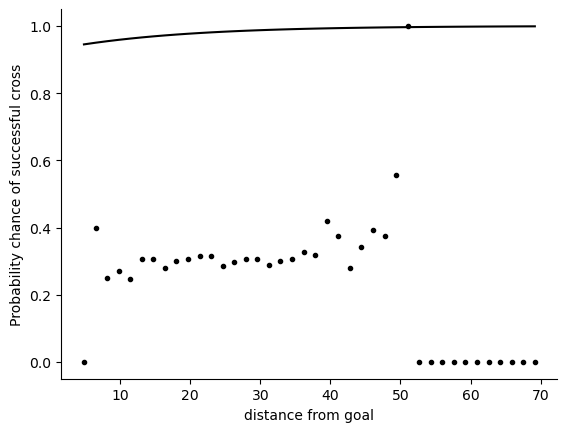

In [20]:
#ValueError: x and y must have same first dimension, but have shapes (41,) and (40,)
middis= (dis[:-1] + dis[1:])/2

#plotting the probabilty of successful using distance from goal
xCprob=1/(1+np.exp(b[0]+b[1]*middis)) 
fig,ax=plt.subplots(num=1)
ax.plot(middis, prob_succ, linestyle='none', marker= '.', color='black')
ax.plot(middis, xCprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance of successful cross')
ax.set_xlabel("distance from goal")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
#fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")   




In [74]:
cross_model.columns

Index(['Successful', 'X', 'Y', 'matchId', 'matchPeriod', 'Sec', 'C',
       'Distance', 'Angle', 'Corner', 'Goal', 'height', 'inverted'],
      dtype='object')

In [98]:
cross_model.dtypes

Successful      object
X               object
Y               object
matchId        float64
matchPeriod     object
Sec            float64
C              float64
Distance       float64
Angle          float64
Corner         float64
Goal           float64
high           float64
inverted       float64
xG             float64
dtype: object

In [35]:
model_variables = ['X','C']#,'X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

In [41]:
#simple model only looking at distance and angle
#Fit the model

test_model = smf.glm(formula="Successful ~ " + model, data=cross_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['Successful[0]', 'Successful[1]']   No. Observations:                12251
Model:                                            GLM   Df Residuals:                    12248
Model Family:                                Binomial   Df Model:                            2
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -7523.5
Date:                                Tue, 25 Oct 2022   Deviance:                       15047.
Time:                                        10:52:04   Pearson chi2:                 1.23e+04
No. Iterations:                                     5   Pseudo R-squ. (CS):           0.005238
Covariance Type:                            nonrobust                                         
                 coef    std err          z      P

In [42]:
#Return xC value for more general model
#sh = row of the shots_model df
#%%capture
def calculate_xC(sh):
#sh = shots_model.iloc[1,:]
    bsum=b[0]
    for i,v in enumerate(model_variables):
        #print(sh[v])
        bsum=bsum+b[i+1]*sh[v]
    xC = 1/(1+np.exp(bsum)) 
    return xC   
#xG
#Add an xG to my dataframe
#usiong apply function, only works if input to the function is a row




In [39]:
pgoal_2d=np.zeros((65,65))

for x in range(65):
    for y in range(65):
        sh=dict()
        #a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        
        #sh['Angle'] = P2Gangle(x,y)
        sh['X'] = x
        sh['C'] = y
        #sh['X'] = x
        #sh['AX'] = x*a
        #sh['X2'] = x**2
        #sh['C'] = abs(y-65/2)
        #sh['C2'] = (y-65/2)**2


sh

{'X': 64, 'C': 64}

(-3.0, 35.0)

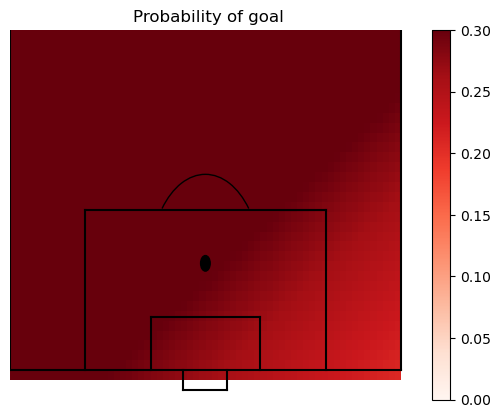

In [44]:
#Create a 2D map of xC
#therefore getting the xC for every possible position on the pitch
#create a df with the fake xs, and ys and hence angles

pgoal_2d=np.zeros((65,65))

for x in range(65):
    for y in range(65):
        sh=dict()
       # a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        
        #sh['Angle'] = P2Gangle(x,y)
        sh['X'] = x
        sh['C'] = y
        #sh['X'] = x
        #sh['AX'] = x*a
        #sh['X2'] = x**2
        #sh['C'] = abs(y-65/2)
        #sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xC(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))

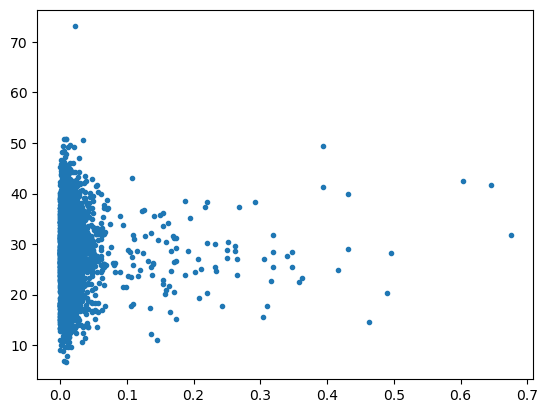

In [64]:
sdf = cross_model.loc[cross_model['Successful']==1,:]
plt.figure()
plt.plot(sdf['xG'],sdf['Distance'],'.')
#plt.axis([0.2,0.7,0,70])